macd指标概念：
平滑异同移动平均线 (Moving Average Convergence Divergence) 
指数移动平均数指标(Exponential Moving Average，EXPMA或EMA)
由于macd概念清晰，但有很多不同说法，所以我们在一下说法与概念对应如下：
短期ema ema(close, 12)
长期ema ema(close, 26)
离差值 dif = ema(close, 12) - ema(close, 26)
离差平均值 dea = ema(dif, 9)
柱 histogram = (dif - dea) * 2

macd到底是什么？
因为dif是macd指标的核心, 所以有时候也叫dif为macd
因为有时候不体现histogram的命名, 所以也叫 histogram 为macd
因为有时候dea的说法比较不稳定, 所以也会叫 dea为macd
我们认为macd是一个整体概念,不是哪条线

# 导入相关模块

In [1]:
import os # 操作系统库
import json # 处理json格式的数据
import requests # 发起网络请求
import pandas as pd # 优秀的分析数据工具
import numpy as np # 处理数字的工具
import matplotlib.pyplot as plt # 强大的画图工具

In [2]:
def run():
    ''' 主程序, 用来调度各个重要流程 '''
    print('正在下载')
    kline = download()
    df = init_df(kline)

    windows = [5, 10, 20, 60]
    df = ma_lines(df, windows)
    df = macd_lines(df)

    draw(df, windows)
    df.to_csv('lesson7.csv', index=False)

In [3]:
def download():
    '''抓取数据'''
    response = requests.get(
        'http://yunhq.sse.com.cn:32041/v1/sh1/dayk/600519?callback=jQuery111205234775875526079_1542185571865&select=date%2Copen%2Chigh%2Clow%2Cclose%2Cvolume&begin=-1000&end=-500&_=1542185571881',
        headers={'Referer': 'http://www.sse.com.cn/market/price/trends/'}
    )

    # 针对结果进行格式处理
    json_str = response.text[42:-1]
    data = json.loads(json_str)
    return data['kline']


In [4]:
def init_df(kline):
    ''' 根据K线数据，创建含有日期与收盘价的矩阵 '''
    df = pd.DataFrame({})
    df['date'] =  [x[0] for x in kline]
    df['close'] = [x[4] for x in kline]

    return df

In [5]:
def ma_lines(df, windows):
    for window in windows:
        name = 'ma%s' % (window)
        df[name] = df['close'].rolling(window).apply(lambda x: sum(x) / len(x), raw=True)
    return df

In [6]:
def macd_lines(df):
    '''生成macd的各种指标'''
    df['ema12'] = ema_lines(df, 'close', 12) #短期ema
    df['ema26'] = ema_lines(df, 'close', 26) #长期ema
    df['dif'] = df['ema12'] - df['ema26'] #离差值
    df['dea'] = ema_lines(df, 'dif', 9) #离差平均值
    df['histogram'] = (df['dif'] - df['dea']) * 2 #柱
    return df

ema初值
方法1 使用第一个收盘价
方法2 前几天的收盘价平均值
方法3 (H+L+2C)/4
方法4 迭代平滑因子,从1不断接近设定的alpah 此处采用最简单与常见的方法1

重要参数 12 26 9这几个参数是在追踪经验上发现比较合适的, 也是最主流的用法
2倍的 dif - dea 按理说, 差值已经体现了两条线的关系, 不需要再乘以2
不过, 很多地方都约定俗成, 乘以2来放大差距,方便观察
我们直接使用pandas提供的ewm

In [7]:
def ema_lines(df, from_label, N):
    '''生成ema指标，直接使用pandas提供的ewm'''
    line = df[from_label].ewm(alpha=2/(N+1), adjust=False).mean()

    # 为了与多数平台保持一致,保留3位小数
    return round(line, 3)

In [8]:
def draw(df, windows):
    ''' 画图 '''
    # 创建画板
    plt.figure(figsize=(7, 4))

    # 准备横坐标
    count = df.count()['close']
    index = np.arange(count)
    df['index'] = index

    # 设置横坐标的刻度与显示标签
    limit = 20
    plt.subplot(211)
    # plt.xticks(index[::limit], df['date'][::limit])

    # 画收盘价曲线
    plt.xlabel('date')
    plt.ylabel('close')
    l_close, = plt.plot(index, df['close'], 'black', label='close')
    legend_handles_close = [l_close]

    for window in windows:
        name = 'ma%s' % (window)
        l_ma, = plt.plot(index, df[name], label=name)
        legend_handles_close.append(l_ma)
    plt.legend(handles=legend_handles_close)

    plt.subplot(212)
    plt.xticks(index[::limit], df['date'][::limit])

    plt.xlabel('date')
    plt.ylabel('macd')
    macd_labels = ['ema12', 'ema26', 'dif', 'dea', 'histogram']
    l_dif, = plt.plot(index, df['dif'], label='dif')
    l_dea, = plt.plot(index, df['dea'], label='dea')
    plt.bar(index, df['histogram'])
    legend_handles_macd = [l_dif, l_dea]

    plt.legend(handles=legend_handles_macd)
    plt.show()

正在下载


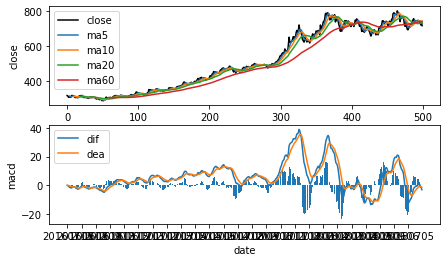

In [9]:
if __name__ == '__main__':
    run()

通过上图分析，我们看到贵州茅台的macd指标上涨十分快速，且收盘价也在稳步上涨。